In [2]:
import sys
lib_dir = "g:/My Drive/Storage/Github/hyuckjinkim"
sys.path.append(lib_dir)

In [3]:
from lib.python.torch import seed_everything

In [44]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

In [6]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import AllChem, rdDepictor, MolFromSmiles, Descriptors, rdMolDescriptors, Crippen, QED, EState, Lipinski, MolSurf, Fragments

In [7]:
# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

In [8]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [9]:
seed_everything(CFG['SEED'])

In [10]:
# data load
train_df = pd.read_csv('data/train.csv')
test_df  = pd.read_csv('data/test.csv')

# get available columns
train_df = train_df[['IC50_nM','pIC50','Smiles']]

# Smiles is unique
train_df['Smiles'].value_counts().sort_values()

# check data head
train_df.head()

,IC50_nM,pIC50,Smiles
0,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


In [ ]:
EState.EState_VSA.Es

In [103]:
# SMILES에서 뽑아올 수 있는 요소
train_df['Mol'] = train_df['Smiles'].apply(Chem.MolFromSmiles)
test_df ['Mol'] = test_df ['Smiles'].apply(Chem.MolFromSmiles)

descriptor_functions = [
    Descriptors.FpDensityMorgan1, Descriptors.FpDensityMorgan2, Descriptors.MaxPartialCharge
]

Estate_functions = [
    EState.EState_VSA.EState_VSA1, EState.EState_VSA.EState_VSA2, EState.EState_VSA.EState_VSA4, EState.EState_VSA.EState_VSA7, 
    EState.EState_VSA.EState_VSA8, EState.EState_VSA.EState_VSA10, EState.EState.MaxEStateIndex, EState.EState.MinEStateIndex,
]

Lipinski_functions = [
    Lipinski.NHOHCount, Lipinski.NOCount, Lipinski.NumAromaticCarbocycles,
    Lipinski.NumAromaticRings, Lipinski.NumHeteroatoms, Lipinski.RingCount,
    Lipinski.NumSaturatedHeterocycles, Lipinski.NumSaturatedRings,
]
Lipinski_function_names = ["NHOHCount", "NOCount", "NumAromaticCarbocycles", "NumAromaticRings", "NumHeteroatoms", "RingCount", "NumSaturatedHeterocycles", "NumSaturatedRings"]

MolSurf_functions = [
    MolSurf.LabuteASA, MolSurf.PEOE_VSA13, MolSurf.PEOE_VSA14, MolSurf.PEOE_VSA2, 
    MolSurf.PEOE_VSA3,  MolSurf.PEOE_VSA6, MolSurf.PEOE_VSA7, MolSurf.SMR_VSA1, 
    MolSurf.SMR_VSA3, MolSurf.SMR_VSA4, MolSurf.SMR_VSA5, MolSurf.SMR_VSA7, 
    MolSurf.SlogP_VSA3, MolSurf.SlogP_VSA5, MolSurf.SlogP_VSA6, MolSurf.TPSA, 
]
MolSurf_function_names = ["LabuteASA", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA6", "PEOE_VSA7", "SMR_VSA1",
                        "SMR_VSA3", "SMR_VSA4", "SMR_VSA5", "SMR_VSA7", "SlogP_VSA3", "SlogP_VSA5", "SlogP_VSA6", "TPSA"]

Fragments_functions = [
    Fragments.fr_Al_COO, Fragments.fr_Al_OH_noTert, Fragments.fr_Ar_COO, Fragments.fr_Ar_N, Fragments.fr_Ar_NH, 
    Fragments.fr_Ar_OH, Fragments.fr_COO, Fragments.fr_C_O, Fragments.fr_NH0, Fragments.fr_amide, 
    Fragments.fr_benzene, Fragments.fr_NH1, Fragments.fr_Ndealkylation2, Fragments.fr_Nhpyrrole, Fragments.fr_ester, 
    Fragments.fr_ether, Fragments.fr_bicyclic, Fragments.fr_ketone, Fragments.fr_para_hydroxylation, Fragments.fr_phenol, 
    Fragments.fr_phenol_noOrthoHbond, Fragments.fr_thiophene,
    ]
Fragments_function_names = ["fr_Al_COO", "Al_OH_noTert", "Ar_COO", "fr_Ar_N", "fr_Ar_NH", "fr_Ar_OH", "fr_COO2", "fr_C_O", "fr_NH0", "fr_amide", "fr_benzene",
                            "fr_NH1", "fr_Ndealkylation2", "fr_Nhpyrrole", "fr_ester", "fr_ether", "fr_bicyclic", "fr_ketone", "fr_para_hydroxylation", 
                            "fr_phenol", "fr_phenol_noOrthoHbond", "fr_thiophene",]

def count_alcohol_substructures(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        alcohol_pattern = Chem.MolFromSmarts('[OX2H]')
        return len(mol.GetSubstructMatches(alcohol_pattern))
    except:
        return None

for func in descriptor_functions:
    train_df[func.__name__] = train_df['Mol'].apply(func)
    test_df [func.__name__] = test_df ['Mol'].apply(func)

for func in Estate_functions:
    train_df[func.__name__] = train_df['Mol'].apply(func)
    test_df [func.__name__] = test_df ['Mol'].apply(func)

for idx, func in enumerate(Lipinski_functions):
    col_name = Lipinski_function_names[idx]
    train_df[col_name] = train_df['Mol'].apply(func)
    test_df [col_name] = test_df ['Mol'].apply(func)

for idx, func in enumerate(MolSurf_functions):
    col_name = MolSurf_function_names[idx]
    train_df[col_name] = train_df['Mol'].apply(func)
    test_df [col_name] = test_df ['Mol'].apply(func)

for idx, func in enumerate(Fragments_functions):
    col_name = Fragments_function_names[idx]
    train_df[col_name] = train_df['Mol'].apply(func)
    test_df [col_name] = test_df ['Mol'].apply(func)
    
train_df['QED'] = train_df['Mol'].apply(QED.qed)
test_df ['QED'] = test_df ['Mol'].apply(QED.qed)
train_df['Alcohol_Count'] = train_df['Smiles'].apply(count_alcohol_substructures)
test_df ['Alcohol_Count'] = test_df ['Smiles'].apply(count_alcohol_substructures)

train_df.drop(columns=['Mol'], inplace=True)
test_df .drop(columns=['Mol'], inplace=True)

train_df.head()

[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerator
[01:29:37] DEPRECATION WARNING: please use MorganGenerat

,IC50_nM,pIC50,Smiles,FpDensityMorgan1,FpDensityMorgan2,MaxPartialCharge,EState_VSA1,EState_VSA2,EState_VSA4,EState_VSA7,...,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene,QED,Alcohol_Count,Mol
0,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...,0.916667,1.680556,0.251986,30.074543,124.485023,56.930024,18.199101,...,5,2,0,0,0,0,0,0.059187,0,<rdkit.Chem.rdchem.Mol object at 0x00000294813...
1,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,1.230769,2.000000,0.260707,11.772726,24.903872,50.271507,12.132734,...,0,2,0,0,0,0,0,0.479279,1,<rdkit.Chem.rdchem.Mol object at 0x00000294813...
2,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,1.256410,2.025641,0.260707,11.772726,24.903872,45.080176,6.066367,...,1,2,0,0,0,0,0,0.466884,1,<rdkit.Chem.rdchem.Mol object at 0x00000294813...
3,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,1.153846,1.897436,0.260707,24.105351,31.104900,0.000000,4.899910,...,0,2,0,0,0,0,0,0.448013,1,<rdkit.Chem.rdchem.Mol object at 0x00000294813...
4,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,1.014925,1.731343,0.251986,29.509818,61.351228,66.643730,57.470956,...,2,1,0,0,0,0,0,0.045219,1,<rdkit.Chem.rdchem.Mol object at 0x00000294813...


In [12]:
# train_df.drop(['IC50_nM','pIC50','Smiles'],axis=1).corr()

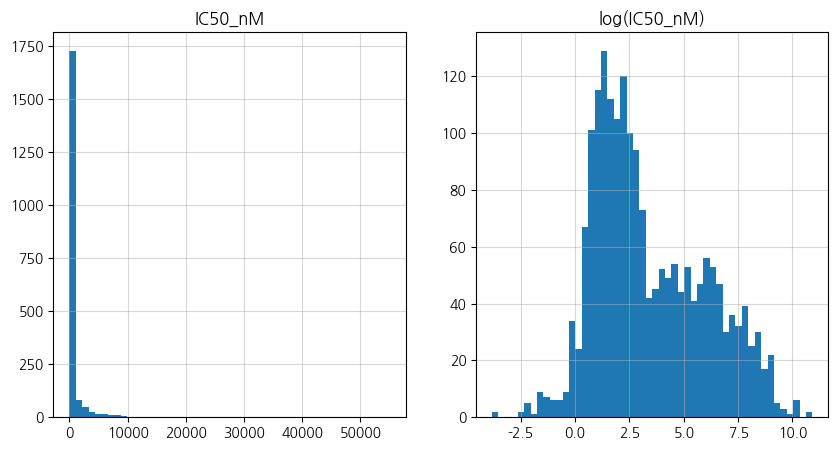

In [13]:
col = 'IC50_nM'
# col = 'pIC50'

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.hist(train_df[col], bins=50)
plt.grid(alpha=0.5)
plt.title(f'{col}')
fig.add_subplot(122)
plt.hist(np.log(train_df[col]), bins=50)
plt.grid(alpha=0.5)
plt.title(f'log({col})')
plt.show()

<Axes: xlabel='pIC50', ylabel='Count'>

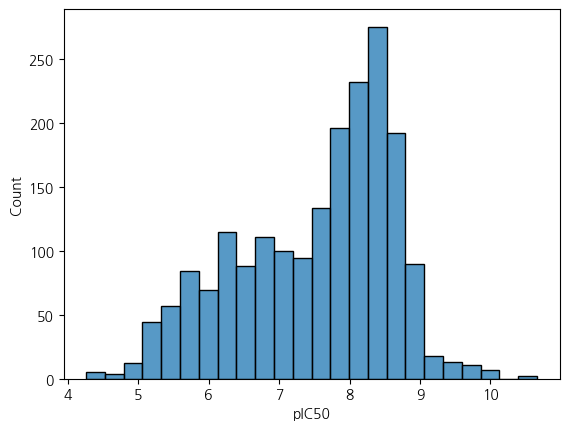

In [14]:
sns.histplot(train_df['pIC50'])

In [49]:
from catboost import CatBoostRegressor, Pool

params = {
    'random_state' : 42,
    'iterations' : 20000,
    'early_stopping_rounds' : 400,
    'learning_rate' : 0.03,
    'loss_function' : 'RMSE', #'MAE'
    #'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
    'use_best_model' : True,
    'allow_writing_files' : False,
    'verbose' : 0,
    'max_depth' : 9,
    'l2_leaf_reg' : 3,
}

In [56]:
target = 'pIC50'
# target = 'IC50_nM'

kf = KFold(n_splits=5, shuffle=True, random_state=CFG['SEED'])

models = []
for tr_idx, val_idx in tqdm(kf.split(train_df), total=5):
    tr_df  = train_df.iloc[tr_idx]
    val_df = train_df.iloc[val_idx]

    model = CatBoostRegressor(**params)
    train_pool = Pool(tr_df .drop(['Smiles','IC50_nM','pIC50'], axis=1), tr_df [target])
    val_pool   = Pool(val_df.drop(['Smiles','IC50_nM','pIC50'], axis=1), val_df[target])

    model.fit(train_pool, eval_set=val_pool)#, metric_period=100)
    models.append(model)

    print('best_iteration:', model.best_iteration_)
    print('best_score:', model.best_score_)

 20%|██        | 1/5 [00:21<01:24, 21.21s/it]

best_iteration: 917
best_score: {'learn': {'RMSE': 0.16749203896022988}, 'validation': {'RMSE': 0.6315973442487725}}


 40%|████      | 2/5 [00:43<01:05, 21.99s/it]

best_iteration: 1002
best_score: {'learn': {'RMSE': 0.17275119710884904}, 'validation': {'RMSE': 0.6094370822544347}}


 60%|██████    | 3/5 [01:00<00:39, 19.65s/it]

best_iteration: 647
best_score: {'learn': {'RMSE': 0.1841852482851989}, 'validation': {'RMSE': 0.6463967704077321}}


 80%|████████  | 4/5 [01:20<00:19, 19.91s/it]

best_iteration: 874
best_score: {'learn': {'RMSE': 0.17667969006481257}, 'validation': {'RMSE': 0.5943164701782829}}


100%|██████████| 5/5 [01:35<00:00, 19.15s/it]

best_iteration: 508
best_score: {'learn': {'RMSE': 0.21737062318955874}, 'validation': {'RMSE': 0.64801242875574}}


In [82]:
prediction = []
for model in models:
    p = model.predict(train_df.drop(['Smiles','IC50_nM','pIC50'], axis=1))
    if target=='pIC50':
        p = pIC50_to_IC50(p)
    prediction.append(p.tolist())

prediction = np.mean(prediction,axis=0)
actual = train_df['IC50_nM']

In [83]:
mean_squared_error(actual, prediction)**0.5

1462.067554677237

In [84]:
from lib.python.graph import MatplotlibFontManager
fm = MatplotlibFontManager()
fm.set_korean_font(check=False)

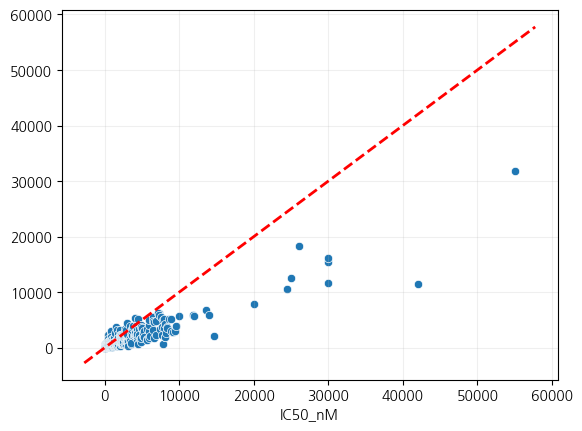

In [85]:
from lib.python.graph import actual_prediction_scatterplot, abline
# actual_prediction_scatterplot(val_true, val_pred)

sns.scatterplot(x=actual, y=prediction)
abline(0,1)
plt.grid(alpha=0.2)

In [90]:
prediction = []
for model in models:
    p = model.predict(test_df.drop(['ID','Smiles'], axis=1))
    if target=='pIC50':
        p = pIC50_to_IC50(p)
    prediction.append(p.tolist())

prediction = np.mean(prediction,axis=0)

In [102]:
submit = pd.read_csv('data/sample_submission.csv')
submit['IC50_nM'] = prediction
submit.to_csv('out/submit_5fold.csv', encoding='utf-8', index=False)

submit.head()

,ID,IC50_nM
0,TEST_000,85.042006
1,TEST_001,18.058191
2,TEST_002,22.548767
3,TEST_003,20.841207
4,TEST_004,17.250125
